<a href="https://colab.research.google.com/github/estrella-celeste/ColabNoteboook/blob/main/EstrDiazU8proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

In [ ]:
!pip install pymc-bart
!pip install preliz

In [ ]:
import pymc_bart as pmb
import preliz as pz
import seaborn as sns

# Unit 8 Project

TO DO:
- Comment a lot
- Finish the project
- Submit project

## Data

The dataset, *COVID-19 Vaccination and Case Trends by Age Group, United States*,  was obtained from [data.gov](https://catalog.data.gov/dataset/covid-19-vaccination-and-case-trends-by-age-group-united-states-e81b4). As the title suggests, it explores the COVID vaccinations and cases by age group for 2020 to 2022 in the US.

In [ ]:
#importing the data set
import pandas as pd
df = pd.read_csv('Archive__COVID-19_Vaccination_and_Case_Trends_by_Age_Group__United_States.csv', dtype={'AgeGroupVacc':'category'})
df

,Date Administered,AgeGroupVacc,7-day_avg_group_cases_per_100k,Administered_Dose1_pct_agegroup,Series_Complete_Pop_pct_agegroup
0,10/11/2022 12:00:00 AM,<2 Years,2.091826,0.052,0.017
1,10/11/2022 12:00:00 AM,12 - 17 Years,2.389293,0.711,0.608
2,10/11/2022 12:00:00 AM,25 - 49 Years,4.375377,0.840,0.710
3,10/10/2022 12:00:00 AM,<2 Years,2.888181,0.052,0.017
4,10/10/2022 12:00:00 AM,2 - 4 Years,3.362708,0.080,0.032
...,...,...,...,...,...
5326,12/14/2020 12:00:00 AM,12 - 17 Years,48.861147,0.000,0.000
5327,12/14/2020 12:00:00 AM,18 - 24 Years,74.352431,0.000,0.000
5328,12/14/2020 12:00:00 AM,25 - 49 Years,72.149347,0.000,0.000
5329,12/14/2020 12:00:00 AM,50 - 64 Years,62.416254,0.000,0.000


In [ ]:
#Renaming columns because they are long or hard to read
df.rename(columns={'7-day_avg_group_cases_per_100k':'WeekGroupCasePer100KAvg','Administered_Dose1_pct_agegroup':'firstDose', 'Series_Complete_Pop_pct_agegroup':'completeDoses'}, inplace=True)

In [ ]:
#this is an array of the age groups,
#except they are given an int (number) label instead of a string (of letters)
group_idx = df.AgeGroupVacc.cat.codes.values

#an array of the strings that represent age groups
group_codes = df.AgeGroupVacc.cat.categories

#puts coords in a dict, so pymc can read them
ageGroups = {"AgeGroupVacc": group_codes}

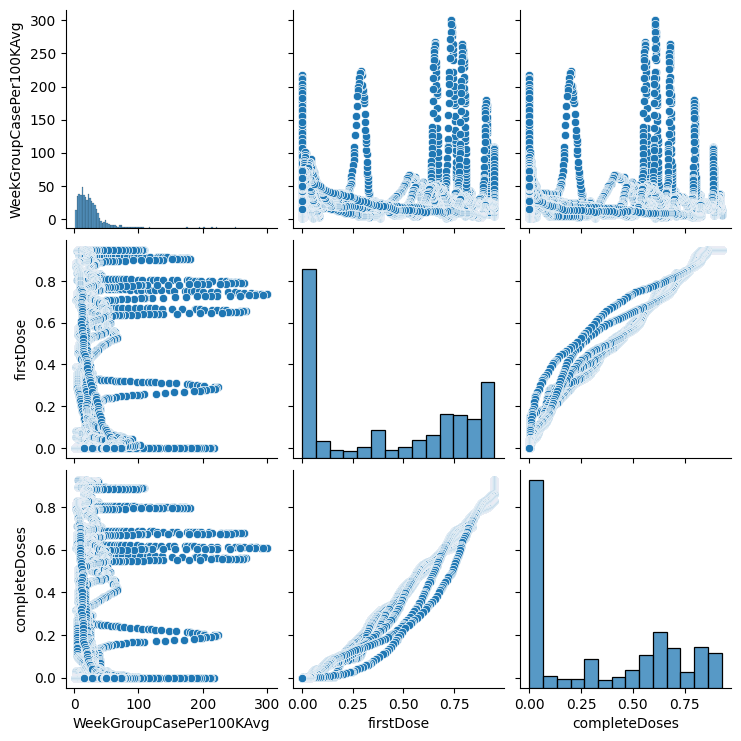

In [ ]:
#use seaborn because it helps find patterns in variables
import seaborn as sbn
sbn.pairplot(df)

The seaborn subplots shows multiple graphs on three different variables. These variables try to show the plot of each combination. So in total it is showing 9 graphs with 3 different variables.

## BART Model

In [ ]:
#Determining the X and Y variables to input to the the BART model
X = df[[ 'firstDose','completeDoses']]    #Combining two variables to X
Y = df["WeekGroupCasePer100KAvg"]         #Determining the other variable

In [ ]:
with pm.Model(coords=ageGroups) as model_vacc:
    s = pm.HalfNormal('s',8) #sigma = 8 is a blind guess
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50) #log around Y
    μ = pm.Deterministic("μ",pm.math.exp(μ_)) #exp it all once BART is done
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y) #likelihood
    idata_vacc = pm.sample(compute_convergence_checks=False)

Output()

Output()

<Axes: xlabel='y'>

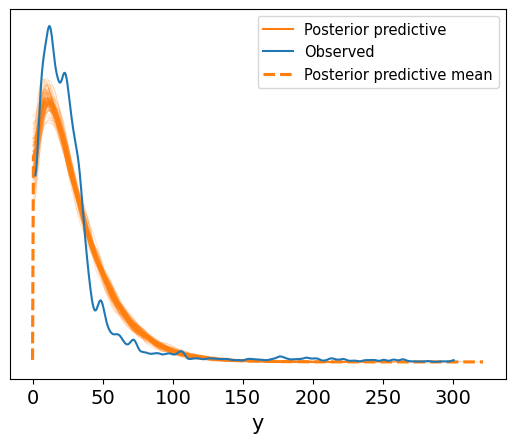

In [ ]:
#posterior predictive dist
pm.sample_posterior_predictive(idata_vacc,model_vacc, extend_inferencedata=True)
az.plot_ppc(idata_vacc, num_pp_samples=100, colors=["C1", "C0", "C1"])

The graph looks like it is capturing the data. But peak seem very low. Though it is trying its best the posterior predictives seems to be fixed with the exception of the peak.

In [ ]:
posterior_mean = idata_vacc.posterior["μ"]

μ_hdi = az.hdi(ary=idata_vacc, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata_vacc, group="posterior_predictive", var_names=["y"]
).T

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


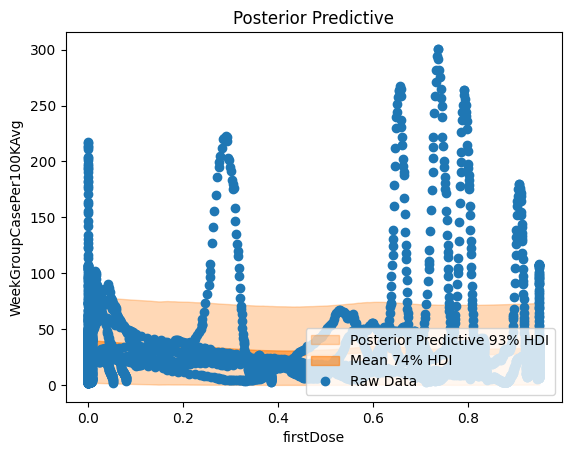

In [ ]:
idx = np.argsort(X.to_numpy()[:,0])
fig, ax = plt.subplots()

az.plot_hdi(
    x=X.to_numpy()[:,0],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive 93% HDI"},
)

az.plot_hdi(
    x=X.to_numpy()[:,0],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean 74% HDI"},
)
ax.plot(df["firstDose"], df["WeekGroupCasePer100KAvg"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="firstDose",
    ylabel="WeekGroupCasePer100KAvg",
);

In [ ]:
posterior_mean = idata_vacc.posterior["μ"]

μ_hdi = az.hdi(ary=idata_vacc, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata_vacc, group="posterior_predictive", var_names=["y"]
).T

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


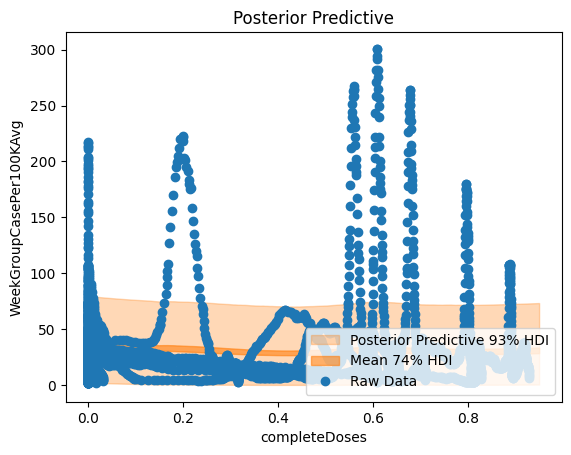

In [ ]:
idx = np.argsort(X.to_numpy()[:,0])
fig, ax = plt.subplots()

az.plot_hdi(
    x=X.to_numpy()[:,0],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive 93% HDI"},
)

az.plot_hdi(
    x=X.to_numpy()[:,0],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean 74% HDI"},
)
ax.plot(df["completeDoses"], df["WeekGroupCasePer100KAvg"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="completeDoses",
    ylabel="WeekGroupCasePer100KAvg",
);

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


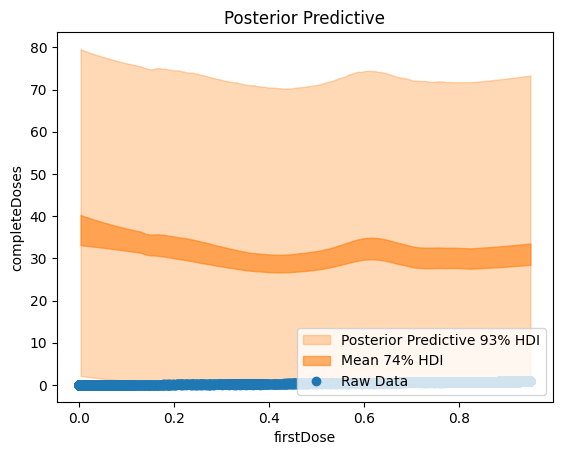

In [ ]:
idx = np.argsort(X.to_numpy()[:,0])
fig, ax = plt.subplots()

az.plot_hdi(
    x=X.to_numpy()[:,0],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive 93% HDI"},
)

az.plot_hdi(
    x=X.to_numpy()[:,0],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean 74% HDI"},
)
ax.plot(df["firstDose"], df["completeDoses"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="firstDose",
    ylabel="completeDoses",
);

These mean and the posterior predictive doesn't capture very well the data and makes a reasonable prediction. In the first two graphs, the mean is mainly accurate but the observed data shows that there may be groups of data. On the other hand, the third graph, shows a mean way higher than the data. That is not correct and I used the wrong variables.

## BART Model 2

Here I am going to do a categorical BART model.

In [ ]:
#importing the data set
import pandas as pd
df2 = pd.read_csv('Archive__COVID-19_Vaccination_and_Case_Trends_by_Age_Group__United_States.csv')

In [ ]:
y_0 = pd.Categorical(df2["AgeGroupVacc"]).codes
x_0 = df2[["7-day_avg_group_cases_per_100k", "Administered_Dose1_pct_agegroup", "Series_Complete_Pop_pct_agegroup"]]

In [ ]:
_, ageGroup = pd.factorize(df2["AgeGroupVacc"], sort=True)
ageGroup

Index(['12 - 17 Years', '18 - 24 Years', '2 - 4 Years', '25 - 49 Years',
       '5 - 11 Years', '50 - 64 Years', '65+ Years', '<2 Years'],
      dtype='object')

In [ ]:
coords = {"n_obs": np.arange(len(x_0)), "AgeGroup": ageGroup}

In [ ]:
with pm.Model(coords=coords) as model_vacc:
    μ = pmb.BART("μ", x_0, y_0, m=50, dims=["AgeGroup", "n_obs"])
    θ = pm.Deterministic("θ", pm.math.softmax(μ, axis=0))
    y = pm.Categorical("y", p=θ.T, observed=y_0)

In [ ]:
with model_vacc:
    idata = pm.sample(chains=4, compute_convergence_checks=False, random_seed=123)
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Output()

In [ ]:
az.plot_ppc(idata, num_pp_samples=100, colors=["C1", "C0", "C1"])

The plot categorizes the groups in numbers. Though the predictions aren't centered in on

In [ ]:
posterior_mean = idata_vacc.posterior["μ"]

μ_hdi = az.hdi(ary=idata_vacc, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata_vacc, group="posterior_predictive", var_names=["y"]
).T

In [ ]:
idx = np.argsort(X.to_numpy()[:,0])
fig, ax = plt.subplots()

az.plot_hdi(
    x=X.to_numpy()[:,0],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive 93% HDI"},
)

az.plot_hdi(
    x=X.to_numpy()[:,0],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean 74% HDI"},
)
ax.plot(df["AgeGroupVacc"], df["7-day_avg_group_cases_per_100k"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="agegroup",
    ylabel="cases",
);

## BART3

In [ ]:
#importing the data set
import pandas as pd
df3 = pd.read_csv('Archive__COVID-19_Vaccination_and_Case_Trends_by_Age_Group__United_States.csv')

In [ ]:
y_0 = pd.Categorical(df3["Date Administered"]).codes
x_0 = df3[["7-day_avg_group_cases_per_100k", "Administered_Dose1_pct_agegroup", "Series_Complete_Pop_pct_agegroup"]]

In [ ]:
_, date = pd.factorize(df3["Date Administered"], sort=True)
ageGroup

In [ ]:
coords1 = {"n_obs": np.arange(len(x_0)), "date": date}

In [ ]:
with pm.Model(coords=coords1) as model_vacc:
    μ = pmb.BART("μ", x_0, y_0, m=50, dims=["date", "n_obs"])
    θ = pm.Deterministic("θ", pm.math.softmax(μ, axis=0))
    y = pm.Categorical("y", p=θ.T, observed=y_0)

In [ ]:
with model_vacc:
    idata2 = pm.sample(chains=4, compute_convergence_checks=False, random_seed=123)
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

 Progress                                   Draws   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   7       46.30 s/draws    0:34:19   -:--:--    
  ╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   35      58.05 s/draws    0:34:19   -:--:--    
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0       0.00 draws/s     0:34:19   -:--:--    
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0       0.00 draws/s     0:34:19   -:--:--

In [ ]:
az.plot_ppc(idata2, num_pp_samples=100, colors=["C1", "C0", "C1"])